# TP53 Exploratory Notebook

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


## Set up initial dataframes and variables

In [3]:
gene='TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.S241del', 'p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

## Test and plot a single protein

PSMA4: 0.0001321921352930831


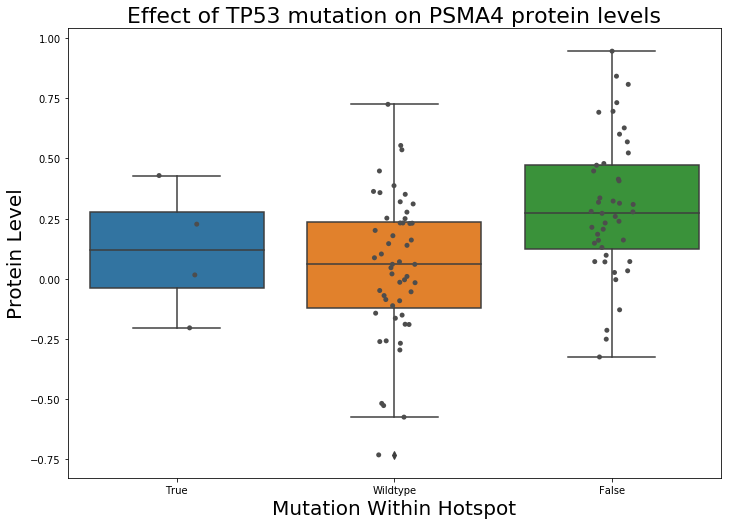

In [11]:
gene = 'PIK3CA'
protein = 'PSMA4'

p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
p53_mutations_protein['Within_Hotspot'] = False
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
if len(mutated) > 2:
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        print(protein + ": " + str(ttest[1]))
else:
    print("There are not enough mutations within the hotspot to do a t-test")
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
boxplt.set_title("Effect of TP53 mutation on " + protein + " protein levels", fontsize='22')
plt.show()

In [8]:
pcutoff = 0.001
pcutoff

0.001

In [9]:
significant_mut_wt = {}
gene = 'PIK3CA'

for protein in proteomics.columns:
    if (protein != 'idx') and (protein != gene):
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) < 2: continue
        if len(wt) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if ttest[1] <= pcutoff:
            significant_mut_wt[protein] = ttest[1]
            
significant_mut_wt

{'CASP7': 0.00045976572239083514,
 'CCDC25': 0.0004116814302809243,
 'DYRK1B': 0.0004286641068681629,
 'EIF3K': 0.0007121645498727077,
 'GDPGP1': 0.0008954766880749995,
 'PSMA4': 0.0001321921352930831,
 'RRAGC': 0.00031933594717525047}

In [13]:
CPTAC.get_transcriptomics()

idx   A1BG  A1BG-AS1  A1CF    A2M  A2M-AS1  A2ML1  A2MP1  A3GALT2  A4GALT  \
S001  4.02      2.16  3.27  13.39     5.88   6.79   1.55     0.97   10.34   
S002  4.81      2.21  4.86  13.24     5.93   6.33   0.93     0.00   10.83   
S003  6.24      6.43  3.68  14.32     6.53   9.42   2.79     0.00   10.98   
S005  5.31      4.87  5.59  13.77     6.35   4.22   2.97     0.00    8.68   
S006  9.84      8.83  7.00  13.12     6.49   6.83   1.80     0.00   11.42   
S007  5.03      5.59  4.82  14.13     7.65   7.75   1.59     1.01    9.61   
S008  3.17      3.56  3.98  13.49     6.48   5.88   2.23     1.16    9.71   
S009  6.03      5.46  7.21  13.67     6.95   6.69   2.93     0.00    8.78   
S010  6.02      5.90  7.73  14.30     7.76   8.47   3.47     1.18    9.98   
S011  5.71      5.43  4.20  14.97     6.87   9.96   2.83     0.00   10.22   
S012  5.17      4.89  4.37  13.40     5.69   8.69   1.98     2.79   11.42   
S013  5.99      5.35  5.54  13.47     5.97   4.74   2.80     0.99   10.46   
S014  5.38      4.83  2.15  14.13     5.96  11.45   1.44     0.00   10.20   
S015  5.95      5.14  6.49  13.10     7.00   3.32   2.55     1.55    6.57   
S016  5.86      6.51  6.17  13.15     7.21   3.65   1.15     0.00    8.37   
S017  3.27      3.60  5.98  12.28     6.23   6.97   3.03     0.00   10.04   
S018  4.65      4.63  4.84  13.42     7.33  10.75   0.00     0.00   10.05   
S019  4.33      4.08  3.94  13.06     5.71  13.60   1.82     0.00   10.04   
S020  4.58      5.16  2.85  15.05     6.74   8.90   3.02     0.92   10.71   
S021  4.60      4.64  5.74  12.69     6.85   9.56   1.54     1.54    9.60   
S022  4.90      4.49  6.51  14.13     5.82   5.44   0.00     1.28    9.49   
S023  4.03      4.11  4.20  13.07     6.14   4.46   1.66     0.78    7.10   
S024  4.62      3.83  3.95  14.12     6.35  11.77   1.43     0.89   10.29   
S025  5.46      4.96  4.75  13.98     7.25   3.94   1.95     1.54   10.04   
S026  5.73      5.03  4.43  14.70     6.87   8.07   2.48     0.00    9.90   
S027  4.13      2.36  3.56  13.13     5.24   4.68   0.00     1.74   10.74   
S028  6.08      5.48  4.58  15.56     7.35   5.92   2.14     2.14   10.17   
S029  5.24      4.88  3.82  14.48     6.87   5.87   2.92     1.53   10.02   
S030  7.36      6.61  3.98  14.15     6.90   8.97   2.87     1.04   10.23   
S031  5.73      4.58  4.38  13.36     6.86   5.60   0.00     0.93   10.06   
...    ...       ...   ...    ...      ...    ...    ...      ...     ...   
S088  6.65      7.28  3.84  13.37     6.28   5.12   1.88     0.92   10.17   
S089  4.78      3.31  2.16  14.00     5.89   4.33   2.16     0.90    9.17   
S090  7.44      6.98  5.10  14.90     8.40   5.22   3.13     0.00    9.63   
S091  3.79      4.46  2.08  15.16     6.52   9.16   2.33     0.00    8.98   
S092  6.94      6.75  3.95  13.08     6.55   6.25   1.38     0.85   10.28   
S093  4.95      5.48  1.55  14.86     7.25   9.54   2.96     0.98   10.81   
S094  5.34      5.77  3.75  13.84     8.44   7.95   4.25     0.00    9.17   
S095  5.22      5.50  6.00  14.73     7.16   7.26   1.58     0.00    8.77   
S096  5.63      6.89  3.55  13.96     7.40  11.41   2.40     0.00    7.80   
S097  7.63      7.54  4.98  13.49     7.01   6.43   0.95     1.51    8.99   
S098  4.85      3.44  4.37  12.88     6.38   8.45   2.38     0.00    9.64   
S099  4.84      4.95  2.77  13.37     6.43   5.90   1.96     1.29    9.84   
S100  4.80      5.02  2.87  13.40     7.15   5.12   0.93     0.00   10.64   
S101  5.95      5.92  5.53  14.23     7.64  11.96   1.73     0.00    8.05   
S102  5.25      5.97  5.04  13.75     6.02   2.06   1.04     0.00    9.87   
S103  6.79      6.72  7.97  14.96     7.24   7.50   2.44     0.00    8.83   
S105  6.42      6.35  2.73  16.07     9.19   4.96   3.44     0.00    8.96   
S106  7.04      7.15  3.96  16.09     8.50   4.43   3.47     0.00    9.24   
S107  6.82      7.27  3.70  16.28     8.04   4.82   3.93     1.67    9.03   
S108  7.24      7.11  3.67  15.41     8.64   4.65   4.61     0.00    9.09